In [1]:
from sstadex import Macromodel, Primitive, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, diffpair_cc
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify

from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")


XSCHEM_RCFILE = "/opt/pdks/sky130A/libs.tech/xschem/xschemrc"
SPICE_DIR = "./spice/"
OUTPUT_DIR = "./output/"
XSCHEM_DIR = "./xschem/"

class test:
    def __init__(self, composed = 0, parametros ={}, lamb = None, target_param = ""):
        self.composed = composed
        self.parametros = parametros
        self.lamd = lamb
        self.target_param = target_param
    def eval(funct):
        return {"eval": funct}
    
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                     # LDO output voltage
Vin = 3.3                                      # LDO supply voltage
Vref = 1.35                                     # LDO voltage reference
IL = 100e-3                                      # Load current
CL = 10e-6                                        # Load capacitance
RL = Vout/IL

## LDO specifications
    
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

Is1 = 25e-6
Is2 = 25e-6

In [2]:
## LDO MACROMODEL

Vg = np.linspace(Vin - (Vin - Vout), 2.5, 5)

LDO_macro = Macromodel(name = "ldo",
                       outputs = [Symbol("W_pt"), Symbol("L_pt")],
                       electrical_parameters = {"Vdd": Vin, 
                                                "Vref": Vref, 
                                                "Vout": Vout, 
                                                "Vaout": 1.7,
                                                "Il": IL} 
                       )

LDO_macro.area_conditions = [10e-3, 0]

## 2stage_OTA MACROMODEL

Vg_ota = np.linspace(LDO_macro.electrical_parameters["Vdd"] - (LDO_macro.electrical_parameters["Vdd"] - LDO_macro.electrical_parameters["Vaout"]), LDO_macro.electrical_parameters["Vdd"], 5)

stage2_OTA_macro = Macromodel(name = "stage2_OTA",
                              outputs=[Symbol("W_2stage"), Symbol("L_2stage")],
                              macromodel_parameters={Symbol('Ra'): np.logspace(3, 7, N_points),
                                                     Symbol('gma'): np.logspace(-5, -2, N_points),
                                                     Symbol('Ca'): np.logspace(-17, -12, N_points)},
                              electrical_parameters = {"Vdd": LDO_macro.electrical_parameters["Vdd"], 
                                                       "Vneg": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vpos": LDO_macro.electrical_parameters["Vref"], 
                                                       "Vout": LDO_macro.electrical_parameters["Vaout"],
                                                       "Vaouts1": 1.6}
                              )
stage2_OTA_macro.area_conditions = [10e-3, 1, 1, 1]

## 1stage_OTA MACROMODEL

OTA_macro = Macromodel(name = "ota_cap",
                       outputs = [Symbol("W_diff_m1"), Symbol("L_diff_m1"), Symbol("W_diff_m2"), Symbol("L_diff_m2"), Symbol("W_aload"), Symbol("L_aload")],
                       req_tfs = [["vout", "vpos"], ["vout", "vpos"]],
                       macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)},
                       electrical_parameters={Symbol("gdif_2"): Symbol("gdif_1"),
                                              Symbol("Rdif_2"): Symbol("Rdif_1")}
                      )

OTA_macro.area_conditions = [10e-3, 1, 1, 1]

In [3]:
## PASS TRANSISTOR MACROMODEL

pt = cs_pmos(netlist='pmos_cm.spice', 
             type='pmos', 
             inputs={'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'vgs_lut': (-2, -0.1, 0.01), 
                     'vgs': LDO_macro.electrical_parameters["Vaout"]-LDO_macro.electrical_parameters["Vdd"], 
                     'il': LDO_macro.electrical_parameters["Il"],
                     'length': lengths, 
                     '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
                 Symbol('Ro_pt'): np.asarray(pt.Ro).flatten()}
pt.outputs = {Symbol("W_pt"): np.asarray(pt.W).flatten(),
              Symbol("L_pt"): np.asarray(pt.L).flatten()}

## OTA stage2 transistor MACROMODEL

stage2_t = cs_pmos(netlist='pmos_cm', 
                   type='pmos', 
                   inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vout"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'vgs_lut': (-2, -0.1, 0.01), 
                           'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                           'il': Is2,
                           'length': lengths, 
                           '2d_var': ['length', 'vgs']})
stage2_t.build()

stage2_t.parameters = {Symbol('gm_stage2'): np.asarray(stage2_t.gm).flatten(),
                 Symbol('Ro_stage2'): np.asarray(stage2_t.Ro).flatten()}
stage2_t.outputs = {Symbol("W_2stage"): np.asarray(stage2_t.W).flatten(),
                    Symbol("L_2stage"): np.asarray(stage2_t.L).flatten()}

## OTA stage1 differential pair

#vs = np.linspace(0.3, 1.25, 20)
#vds_diffpar = stage2_OTA_macro.electrical_parameters["Vaouts1"] - vs
#vgs_diffpar = stage2_OTA_macro.electrical_parameters["Vpos"] - vs

#diffpair_primitive = simplediffpair(netlist='simplediffpair', 
#                                    type='nmos', 
#                                    inputs={'vds_lut': (0.1, 2, 0.01),
#                                            'vgs_lut': (0.1, 2.2, 0.01), 
#                                            'vds': vds_diffpar, 
#                                            'vgs': vgs_diffpar, 
#                                            'il': Is1,
#                                            'length': lengths, 
#                                            '2d_var': ['vds', 'vgs']})

#diffpair_primitive.build()      

#diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
#                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
#                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd).flatten(),
#                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs).flatten()}
#diffpair_primitive.outputs = {Symbol("W_diff"): np.asarray(diffpair_primitive.W).flatten(),
#                              Symbol("L_diff"): np.asarray(diffpair_primitive.L).flatten()}


sweep_size = 3

vin = 1.35
vout = 1.6

vs = np.linspace(0.1, vin-0.1, sweep_size)
vcp = np.linspace(vin, vout-0.1, sweep_size)

diffpair_primitive = diffpair_cc(vcp, vs, vin, vout, 20e-6, sweep_size, lengths)

diffpair_primitive.build()      

diffpair_primitive.parameters = {Symbol("Rdif_1"): np.asarray(diffpair_primitive.Ro).flatten(), 
                                 Symbol("gdif_1"): np.asarray(diffpair_primitive.gm).flatten(),
                                 Symbol("Cgd"): np.asarray(diffpair_primitive.cgd_m1).flatten(),
                                 Symbol("Cgs"): np.asarray(diffpair_primitive.cgs_m1).flatten(),
                                 Symbol("Rdif_m1_1"): np.asarray(diffpair_primitive.Ro_m1).flatten(), 
                                 Symbol("gdif_m1_1"): np.asarray(diffpair_primitive.gm_m1).flatten(),
                                 Symbol("Rdif_m2_1"): np.asarray(diffpair_primitive.Ro_m2).flatten(), 
                                 Symbol("gdif_m2_1"): np.asarray(diffpair_primitive.gm_m2).flatten(),
                                 Symbol("Cgd_m1"): np.asarray(diffpair_primitive.cgd_m1).flatten(),
                                 Symbol("Cgs_m1"): np.asarray(diffpair_primitive.cgs_m1).flatten(),
                                 Symbol("Cds_m1"): np.asarray(np.abs(diffpair_primitive.cds_m1)).flatten()+np.asarray(np.abs(diffpair_primitive.cgs_m2)).flatten()+1.25e-14,
                                 Symbol("Cds_m2"): np.asarray(diffpair_primitive.cds_m2).flatten(),
                                 Symbol("vbias"): np.asarray(diffpair_primitive.vbias).flatten()}
diffpair_primitive.outputs = {Symbol("W_diff_m1"): np.asarray(diffpair_primitive.W_m1).flatten(),
                              Symbol("W_diff_m2"): np.asarray(diffpair_primitive.W_m2).flatten(),
                              Symbol("L_diff_m1"): np.asarray(diffpair_primitive.L_m1).flatten(),
                              Symbol("L_diff_m2"): np.asarray(diffpair_primitive.L_m2).flatten()}

## OTA stage1 active load

ota_cm_pmos = cm_pmos(name='ota_cm_pmos', 
                      netlist='pmos_cm ', 
                      type='pmos', 
                      inputs={'vds_lut': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'vgs_lut': (-1.8, -0.1, 0.01), 
                              'vgs': stage2_OTA_macro.electrical_parameters["Vaouts1"]-stage2_OTA_macro.electrical_parameters["Vdd"], 
                              'il': Is1,
                              'length': lengths, 
                              '2d_var': ['length', 'vgs']})
ota_cm_pmos.build()

ota_cm_pmos.parameters = {Symbol("Raload_1"): np.asarray(ota_cm_pmos.Ro).flatten(),
                          Symbol("gaload"): np.asarray(ota_cm_pmos.gm).flatten()}
ota_cm_pmos.outputs = {Symbol("W_aload"): np.asarray(ota_cm_pmos.W).flatten(),
                       Symbol("L_aload"): np.asarray(ota_cm_pmos.L).flatten()}

length
vgs
0
length
vgs
0
vds
vgs
1
vds
vgs
1
length
vgs
0


In [4]:
pt.cgg

array([[3.13438255e-12],
       [1.52272873e-11],
       [6.74518671e-11],
       [2.86152016e-10],
       [1.18064452e-09]])

In [5]:
## LDO MACROMODEL

#################### PSRR LDO MACRO #######################
psrr_LDO_macro = test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                   Symbol("V2"): 0,
                   Symbol("s"): 0,
                   Symbol("Rl"): RL,
                   Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                   Symbol("R1"): 100000,
                   Symbol("R2"): 300000}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [10**(-70/20)]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

#################### BW LDO MACRO #######################
bw_LDO_macro = test()
bw_LDO_macro.name = "bw_LDO"
bw_LDO_macro.tf = ["vout", "vdd"]
bw_LDO_macro.netlist = "ldo"
bw_LDO_macro.parametros = {Symbol("V1"): 1,
                  Symbol("V2"): 0,
                  Symbol("Rl"): RL,
                  Symbol("Cl"): CL,
                   Symbol("Cc"): 1e-12,
                  Symbol("R1"): 100000,
                  Symbol("R2"): 300000}
bw_LDO_macro.conditions = {"min": [1e4]}
bw_LDO_macro.variables = {}
bw_LDO_macro.out_def = {"frec": [bw_LDO_macro.tf, -0.70794]}

#################### load regulation LDO MACRO #######################
loadreg_LDO_macro = test()
loadreg_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
loadreg_LDO_macro.parametros = {Symbol("V1"): 1.8,
                      Symbol("V2"): 1.35,
                      Symbol("s"): 0,
                      Symbol("Cl"): CL,
                      Symbol("Cc"): 1e-12,
                      Symbol("R1"): 100000,
                      Symbol("R2"): 300000}
loadreg_LDO_macro.variables = {Symbol('Rl'): [RL, RL+1200]}
loadreg_LDO_macro.out_def = {'diff': [loadreg_LDO_macro.tf, loadreg_LDO_macro.variables]}
loadreg_LDO_macro.conditions = {'max': [1]}

## 2stage_OTA MACROMODEL

#################### PSRR 2 stage OTA #######################
psrr_2stage_OTA = test()
psrr_2stage_OTA.name = "psrr_2stage"
psrr_2stage_OTA.tf = ["vout", "V_p"]
psrr_2stage_OTA.netlist = "stage2_OTA"
psrr_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0, 
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}

psrr_2stage_OTA.opt_goal = "max"
psrr_2stage_OTA.conditions = {"min": [10**(30/20)]}
psrr_2stage_OTA.variables = {}
psrr_2stage_OTA.out_def = {"eval": psrr_2stage_OTA.tf}
 
#################### BW 2 stage OTA #######################
bw_2stage_OTA = test()
bw_2stage_OTA.name = "bw_2stage"
bw_2stage_OTA.tf = ["vout", "V_p"]
bw_2stage_OTA.netlist = "stage2_OTA"
bw_2stage_OTA.parametros = { Symbol("V1"): 0,
                   Symbol("V2"): 1,
                   Symbol("V3"): 0,
                   Symbol("Il"): 0,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 1e-12}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"eval": bw_2stage_OTA.tf}

#################### rout 2 stage OTA #######################
rout_2stage_OTA = test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "stage2_OTA_r"
rout_2stage_OTA.parametros = {Symbol("V1"): 0,
                   Symbol("V2"): 0,
                   Symbol("V3"): 0,
                   Symbol("V4"): 1,
                   Symbol("Ra_1"): 1000,
                   Symbol("I2"): 0,
                   Symbol("Cl"): 0,
                   Symbol("s"): 0}
rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [4.641589e+02]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

#################### gm 2 stage OTA #######################

gm_2stage_OTA = test()
gm_2stage_OTA.target_param = Symbol("gma")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "V_p"]
gm_2stage_OTA.netlist = "stage2_OTA"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [psrr_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"

gm_2stage_OTA.conditions = {"min": [0.0001]}

## 1stage_OTA MACROMODEL

#################### PSRR 1stage OTa #######################
psrr_1stage_OTA = test()
psrr_1stage_OTA.tf = ("vout", "vpos")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_cc_cap"
psrr_1stage_OTA.parametros = {Symbol("gdif_m1_2"): Symbol("gdif_m1_1"),
                              Symbol("gdif_m2_2"): Symbol("gdif_m2_1"),
                                Symbol("Rdif_m1_2"): Symbol("Rdif_m1_1"),
                                Symbol("Rdif_m2_2"): Symbol("Rdif_m2_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("gdif_2"): Symbol("gdif_1"),
                                Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("V1"): 0,
                                Symbol("V_b"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Cl"): 1e-12}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [40]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

#################### BW 1stage OTA #######################

bw_1stage_OTA = test()
bw_1stage_OTA.tf = ("vout", "vpos")
bw_1stage_OTA.name = "bw_1stage"
bw_1stage_OTA.netlist = "ota_cc_cap"
bw_1stage_OTA.parametros = {Symbol("gdif_m1_2"): Symbol("gdif_m1_1"),
                              Symbol("gdif_m2_2"): Symbol("gdif_m2_1"),
                                Symbol("Rdif_m1_2"): Symbol("Rdif_m1_1"),
                                Symbol("Rdif_m2_2"): Symbol("Rdif_m2_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("gdif_2"): Symbol("gdif_1"),
                                Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("V1"): 0,
                                Symbol("V_b"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 1,
                                Symbol("I2"): 0,
                                Symbol("Cl"): 1e-12}
bw_1stage_OTA.conditions = {"min": [1e2]}
bw_1stage_OTA.variables = {}
bw_1stage_OTA.out_def = {"frec": [bw_1stage_OTA.tf, -0.70794]}

#################### rout 1 stage OTA #######################
rout_1stage_OTA = test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_cap_r"
rout_1stage_OTA.parametros = {Symbol("gdif_2"): Symbol("gdif_1"),
                              Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}
rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [1.291550e+03]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

gm_1stage_OTA = test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_cap"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [psrr_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"

gm_1stage_OTA.conditions = {"min": [0.0001]}

In [6]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [stage2_OTA_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0

stage2_OTA_macro.primitives = [stage2_t]
stage2_OTA_macro.submacromodels = [OTA_macro]
stage2_OTA_macro.num_level_exp = -1
stage2_OTA_macro.specifications = [psrr_2stage_OTA, rout_2stage_OTA, gm_2stage_OTA]
stage2_OTA_macro.opt_specifications = [psrr_2stage_OTA]
stage2_OTA_macro.is_primitive = 0

OTA_macro.primitives = [diffpair_primitive, ota_cm_pmos]
OTA_macro.submacromodels = []
OTA_macro.num_level_exp = 1
OTA_macro.specifications = [psrr_1stage_OTA, bw_1stage_OTA]
OTA_macro.opt_specifications = [psrr_1stage_OTA]
OTA_macro.is_primitive = 0

ota1_results, ota1_axes, ota1_primouts, ota1_df = dfs(OTA_macro, debug = False)

############################################
Starting the exploration of:  ota_cap
Netlist:  ota_cc_cap
Running MNA... 



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



   net1  vs  vneg  net2  vpos  vss  vdd  vout  net3  vbias
0     1   2     3     4     5    0    6     7     8      9
[('vout', 'vpos')]
Netlist:  ota_cc_cap
Running MNA... 
   net1  vs  vneg  net2  vpos  vss  vdd  vout  net3  vbias
0     1   2     3     4     5    0    6     7     8      9



   X server connection failed, although DISPLAY shell variable is set.
   A possible reason is that the X server is not running or DISPLAY shell variable
   is incorrectly set.
   Starting Xschem in text only mode.



[('vout', 'vpos')]
{<sstadex.models.primitives.diffpair_cc object at 0x7fa12af7d840>: {Rdif_1: array([           nan, 1.96968507e+07, 9.25531354e+06,            nan,
       4.63556987e+06, 2.17819860e+06,            nan, 1.15511319e+06,
       5.42773812e+05,            nan, 1.78530930e+07, 9.04979561e+06,
                  nan, 4.11512850e+06, 2.08597310e+06,            nan,
       2.08830958e+06, 1.05857147e+06,            nan, 9.09107842e+06,
       5.84972842e+06,            nan, 2.06130483e+06, 1.32636337e+06,
                  nan, 1.19312222e+06, 7.67724206e+05,            nan,
       3.58344998e+07, 1.68382010e+07,            nan, 9.97308029e+06,
       4.68623062e+06,            nan, 1.70553075e+06, 8.01408413e+05,
                  nan, 3.31841026e+07, 1.68211383e+07,            nan,
       8.96357728e+06, 4.54366884e+06,            nan, 4.44748845e+06,
       2.25444753e+06,            nan, 1.72123430e+07, 1.10754222e+07,
                  nan, 4.53320822e+06, 2.91692973e+06

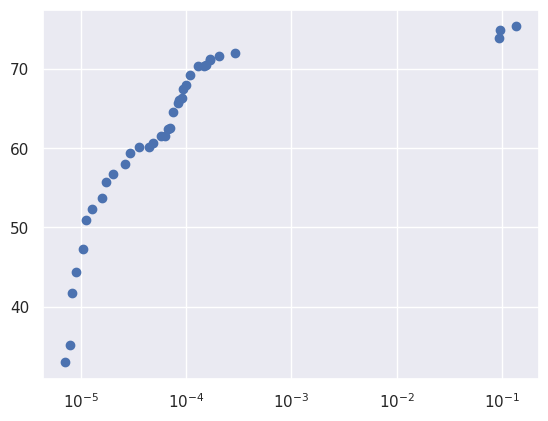

In [7]:
ota1_df["gain"]=20*np.log10(ota1_df["psrr_1stage"])

area = ota1_df["area"]
gain = ota1_df["gain"]

plt.scatter(area, gain)
plt.xscale("log")

In [8]:
ota1_df = ota1_df[(ota1_df[Symbol("W_diff_m1")]>5e-6) & (ota1_df[Symbol("W_diff_m2")]>5e-6) & (ota1_df[Symbol("W_aload")]>5e-6)].sort_values(by="area")

In [11]:
W_diff_m1 = ota1_df[Symbol("W_diff_m1")].values*1e6
L_diff_m1 = ota1_df[Symbol("L_diff_m1")].values*1e6

W_diff_m2 = ota1_df[Symbol("W_diff_m2")].values*1e6
L_diff_m2 = ota1_df[Symbol("L_diff_m2")].values*1e6

W_al_pf = (ota1_df[Symbol("W_aload")].values*1e6)
L_al_pf = (ota1_df[Symbol("L_aload")].values*1e6)

#W_s2_pf = (final_dict[Symbol("W_2stage")].values*1e6)
#L_s2_pf = (final_dict[Symbol("L_2stage")].values*1e6)

mult_diff = []
for idx, i in enumerate(W_diff_m1):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al_pf):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff_m1,
        L_diff_m1,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_diff_m2,
        L_diff_m2,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "XM6": [
        W_al_pf,
        L_al_pf,
        mult_al,
        "pfet",
    ],
    "I2": np.full(len(W_diff_m1), 40e-6),
    "Vbias": ota1_df[Symbol("vbias")].values
}

simulation_results = spice_sim("ota_tb_ihp_cc", values)

[array([  5.86999305,   5.86721247,  11.05914436,  11.05914436,
        47.42861226,  11.05914436,  47.42861226,  47.42861226,
        47.42861226,  62.3383063 ,  47.42861226,  62.3383063 ,
        62.3383063 ,  62.3383063 ,  98.72813872,  47.42861226,
        98.72813872,  62.3383063 ,  98.72813872, 176.78369032,
        47.42861226,  47.42861226,  47.42861226]), array([6.4, 6.4, 0.4, 0.4, 0.8, 0.4, 0.8, 0.8, 0.8, 1.6, 0.8, 1.6, 1.6,
       1.6, 3.2, 0.8, 3.2, 1.6, 3.2, 6.4, 0.8, 0.8, 0.8]), [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1], 'nfet']
test numer:  0
** sch_path: /workspaces/usm-vlsi-tools/shared_xserver/SSTADEx/test/sstadex/xschem/ota_tb_ihp_cc.sch

**.subckt ota_tb_ihp_cc

['I2', 'vs', 'vss', '4e-05']
I2 vs vss 4e-05 

XM1
['XM1', 'vcp', 'vp1', 'vs', 'vs', 'sg13_hv_nmos', 'L=6.3999999999999995u', 'W=5.869993046820324u', 'ng=1', 'm=1']
XM1 vcp vp1 vs vs sg13_hv_nmos L=6.3999999999999995u W=5.869993046820324u ng=1 m=1 

XM2
['XM2', 'net2', 'vn', 'vs'

In [12]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ota1_df["gain_sim"]=gain_error
ota1_df["gain_error"] = (np.abs(np.asarray(gain_error) - ota1_df["gain"].values)/np.asarray(gain_error))*100

In [13]:
fc = []
for i in range(len(simulation_results)):
    x = simulation_results[i].iloc[:,0]
    gain = simulation_results[i].iloc[:,1]
    min = np.argmin(np.abs(gain-(gain[0]-3)))
    fc.append(x[min])  

ota1_df["fc"] = fc
fc

[np.float64(1000000.0),
 np.float64(630957.344),
 np.float64(1995262.31),
 np.float64(1584893.19),
 np.float64(6309573.44),
 np.float64(1000000.0),
 np.float64(1995262.31),
 np.float64(1584893.19),
 np.float64(1258925.41),
 np.float64(1584893.19),
 np.float64(1000000.0),
 np.float64(1000000.0),
 np.float64(630957.344),
 np.float64(316227.766),
 np.float64(501187.234),
 np.float64(199526.231),
 np.float64(316227.766),
 np.float64(158489.319),
 np.float64(125892.541),
 np.float64(125892.541),
 np.float64(251.188643),
 np.float64(251.188643),
 np.float64(158.489319)]

In [14]:
ota1_df

,Rdif_1,gdif_1,Cgd,Cgs,Rdif_m1_1,gdif_m1_1,Rdif_m2_1,gdif_m2_1,Cgd_m1,Cgs_m1,...,L_diff_m1,W_diff_m2,L_diff_m2,W_aload,L_aload,area,gain,gain_sim,gain_error,fc
1169,1.359324e+08,0.000063,-2.465226e-17,1.036335e-13,7.652436e+06,0.000063,8.159789e+04,0.000218,-2.465226e-17,1.036335e-13,...,6.400000e-06,0.000005,4.000000e-07,0.000011,0.000006,0.000035,60.111969,60.417862,0.506295,1.000000e+06
1173,1.365318e+08,0.000063,-3.088485e-17,1.035741e-13,8.185309e+06,0.000063,5.504759e+04,0.000303,-3.088485e-17,1.035741e-13,...,6.400000e-06,0.000014,4.000000e-07,0.000011,0.000006,0.000045,60.120170,60.500127,0.628028,6.309573e+05
953,5.170018e+06,0.000293,-1.886679e-16,6.992027e-15,1.226237e+05,0.000293,2.042203e+05,0.000206,-1.886679e-16,6.992027e-15,...,4.000000e-07,0.000026,1.600000e-06,0.000006,0.000003,0.000048,60.631893,61.058852,0.699258,1.995262e+06
1233,5.170018e+06,0.000293,-1.886679e-16,6.992027e-15,1.226237e+05,0.000293,2.042203e+05,0.000206,-1.886679e-16,6.992027e-15,...,4.000000e-07,0.000026,1.600000e-06,0.000011,0.000006,0.000057,61.482216,61.693225,0.342029,1.584893e+06
855,4.686231e+06,0.000339,-5.767016e-16,5.957888e-14,2.638156e+05,0.000339,8.159789e+04,0.000218,-5.767016e-16,5.957888e-14,...,8.000000e-07,0.000005,4.000000e-07,0.000006,0.000003,0.000062,61.553903,61.391572,0.264418,6.309573e+06
1013,7.172381e+06,0.000293,-1.886679e-16,6.992027e-15,1.226237e+05,0.000293,3.078860e+05,0.000190,-1.886679e-16,6.992027e-15,...,4.000000e-07,0.000045,3.200000e-06,0.000006,0.000003,0.000068,62.458799,63.045243,0.930196,1.000000e+06
913,8.059908e+06,0.000339,-5.767016e-16,5.957888e-14,2.638156e+05,0.000339,1.274259e+05,0.000240,-5.767016e-16,5.957888e-14,...,8.000000e-07,0.000018,8.000000e-07,0.000006,0.000003,0.000076,64.522092,65.013466,0.755804,1.995262e+06
1193,8.059908e+06,0.000339,-5.767016e-16,5.957888e-14,2.638156e+05,0.000339,1.274259e+05,0.000240,-5.767016e-16,5.957888e-14,...,8.000000e-07,0.000018,8.000000e-07,0.000011,0.000006,0.000085,65.663054,65.882141,0.332543,1.584893e+06
965,1.112290e+07,0.000339,-5.767016e-16,5.957888e-14,2.638156e+05,0.000339,2.042203e+05,0.000206,-5.767016e-16,5.957888e-14,...,8.000000e-07,0.000026,1.600000e-06,0.000006,0.000003,0.000085,66.031946,66.667069,0.952679,1.258925e+06
923,1.713147e+07,0.000283,-6.313756e-16,1.850747e-13,5.607445e+05,0.000283,1.274259e+05,0.000240,-6.313756e-16,1.850747e-13,...,1.600000e-06,0.000018,8.000000e-07,0.000006,0.000003,0.000091,66.292867,67.038556,1.112328,1.584893e+06


In [15]:
index = 22

x = simulation_results[index].iloc[:,0]
gain = simulation_results[index].iloc[:,1]
x_1 = simulation_results[index].iloc[:,2]
phase = simulation_results[index].iloc[:,3]*180/np.pi

In [16]:
min = np.argmin(np.abs(gain-(gain[0]-3)))
x[min]

np.float64(158.489319)

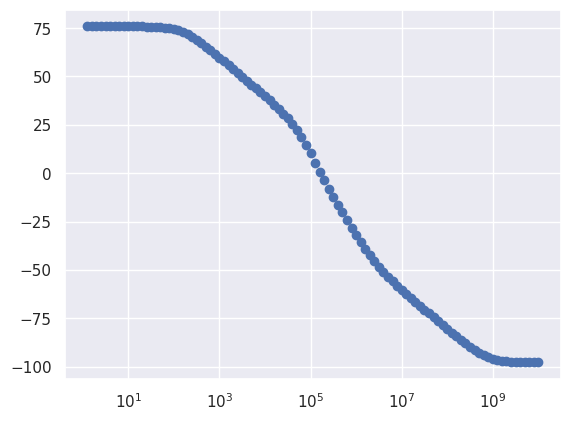

In [17]:
plt.scatter(x, gain)
plt.xscale("log")

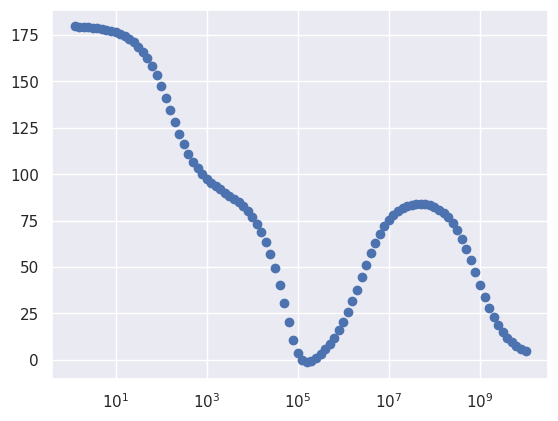

In [18]:
plt.scatter(x_1, phase)
plt.xscale("log")